# 纯因子组合测试示例

本示例文档展示了调用tool_kit中的纯因子组合测试工具进行纯因子组合测试的过程，包括求解纯因子组合权重向量、纯因子组合回测

## 1.工具导入

In [1]:
# 导入tool_kit中的纯因子组合测试工具
import warnings
import matplotlib.pyplot as plt
from tool_kit import db_zcs, pd
from tool_kit.date_N_time import gen_trade_date, shift_date
from tool_kit.base_datastruct import basic_codes
from tool_kit.risk_module_tool import FactorCal
from tool_kit.utility_tool import cal_indicator
warnings.filterwarnings('ignore')
%matplotlib inline

## 2.指定初始参数、传入因子原始数据

In [2]:
# 指定因子测试的开始时间、结束时间、换仓频率、待剔除风格因子
# freq: 换仓频率，str，m月频，w周频，d日频
start_date = '2020-01-01'
end_date = '2020-03-01'
freq = 'm'
remove_factor = [] # 若测试风格因子的纯因子组合，需将该因子从风格因子序列中剔除
factor_date_ls = gen_trade_date(shift_date(start_date, freq, 'pre'), end_date, freq=freq)
date_ls = gen_trade_date(start_date, end_date)

In [3]:
# 提取因子值原始数据factor_df，pandas.DataFrame，index是(股票代码，日期)，columns是因子名称
# 日期只包含换仓日
# 原始数据可包含多个因子，每一列为一个因子，以列名区分
factor_name = '1m_std'
field_dict = {'_id': 0, 'code': 1, 'date': 1, factor_name: 1}
cursor = db_zcs.wind_financial_2014.find({'date': {'$in': factor_date_ls}, 'code': {'$in': basic_codes}}, field_dict)
factor_df = pd.DataFrame(cursor).set_index(['code', 'date'])[factor_name].unstack(level='date')
style_factor_ls = ['barra_beta_v2', 'custom_size', 'custom_value', 'barra_liquidity', 'custom_growth', 'custom_long_m',
                   'custom_short_m', 'custom_vol', 'barra_nlsize']
if remove_factor:
    for f in remove_factor:
        style_factor_ls.remove(f)

In [4]:
factor_df

date,2019-12-31,2020-01-23,2020-02-28
code,,,
000001.SZ,0.012357,0.015454,0.029707
000002.SZ,0.016783,0.018451,0.027846
000004.SZ,0.024895,0.026201,0.065796
000005.SZ,0.013135,0.013858,0.032433
000006.SZ,0.010668,0.012775,0.028031
...,...,...,...
688388.SH,0.035893,0.035237,0.061496
688389.SH,0.027031,0.024253,0.071966
688396.SH,NaN,NaN,NaN


## 3.求解纯因子组合权重向量和组合收益率

In [5]:
# 遍历回测区间的交易日，使用因子暴露矩阵和个股收益率向量进行纯因子组合求解
# 纯因子组合权重，pure_weight_df，pandas.DataFrame，index是日期，columns是股票代码
# 纯因子组合收益率，pure_daily_return_df，pandas.DataFrame，index是日期，columns是因子名称
pure_weight_ls = []
pure_daily_return_df = pd.DataFrame(index=date_ls, columns=[factor_name])
for date in date_ls:
    print(date)
    fc = FactorCal(date=date, universe='A', tom_date=shift_date(date, 2, 'post'), cal_return='custom',
                   style_factor_ls=style_factor_ls, del_extremum=True, neutralize=False)
    factor_date = [d for d in factor_date_ls if d < date][-1]
    fc.cal_pure_portfolio_weight(extra_factor=factor_df.loc[:, factor_date].rename(factor_name))
    pure_daily_return_df.loc[date, factor_name] = fc.factor_return_series[factor_name]
    pure_weight_ls.append(fc.pure_weight_df.loc[factor_name, :].rename(date))
pure_weight_df = pd.concat(pure_weight_ls, axis=1, join='outer').T
pure_daily_return_df = pure_daily_return_df.shift(1).fillna(0)

2020-01-02
2020-01-03
2020-01-06
drop data: 0.00027277686852154935
2020-01-07
2020-01-08
2020-01-09
2020-01-10
2020-01-13
2020-01-14
2020-01-15
2020-01-16
2020-01-17
2020-01-20
2020-01-21
2020-01-22
2020-01-23
2020-02-03
2020-02-04
2020-02-05
2020-02-06
2020-02-07
2020-02-10
2020-02-11
2020-02-12
2020-02-13
2020-02-14
2020-02-17
2020-02-18
2020-02-19
2020-02-20
2020-02-21
2020-02-24
2020-02-25
2020-02-26
2020-02-27
2020-02-28


In [6]:
pure_weight_df

,000957.SZ,000966.SZ,000993.SZ,002002.SZ,000008.SZ,000010.SZ,000026.SZ,000027.SZ,000034.SZ,000040.SZ,...,603815.SH,688025.SH,002965.SZ,688108.SH,002963.SZ,300793.SZ,300799.SZ,688098.SH,688139.SH,688369.SH
2020-01-02,0.065187,-0.012698,0.005101,-0.006853,0.076663,0.048279,0.247367,0.035882,-0.025770,0.028375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,0.061054,-0.013542,0.007830,-0.006086,0.066732,0.045665,0.238792,0.029886,-0.022416,0.029324,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,0.063844,-0.008018,0.007571,-0.001376,0.075453,0.059998,0.233385,0.026818,-0.031997,0.045551,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,0.061260,-0.007599,0.011906,-0.004606,0.074010,0.046732,0.223307,0.024625,-0.027432,0.044965,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,0.063568,-0.000727,0.008283,-0.005960,0.084043,0.046833,0.211968,0.006476,-0.041205,0.046672,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09,0.061595,-0.002476,0.006018,-0.006500,0.074738,0.033554,0.204735,0.005885,-0.068271,0.051282,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-10,0.058549,-0.006679,0.005255,-0.010463,0.074553,0.028290,0.207341,0.004401,-0.070080,0.050522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-13,0.049752,-0.008234,0.005215,-0.014741,0.074303,0.012045,0.209911,0.004765,-0.048073,0.065971,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14,0.048605,-0.008063,0.006011,-0.029579,0.071862,0.006786,0.205325,0.006403,-0.041813,0.073037,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-15,0.045241,-0.007235,0.005751,-0.024676,0.065304,0.011123,0.201396,0.002584,-0.061124,0.081889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4.纯因子组合回测

In [7]:
# 计算纯因子组合回测指标
pure_value_df = (1 + pure_daily_return_df).cumprod()
pure_indicator = cal_indicator(pure_value_df)

In [8]:
pure_indicator

,annualized_returns,max_drawdown,sharpe
1m_std,-1.0,0.902285,-0.773839


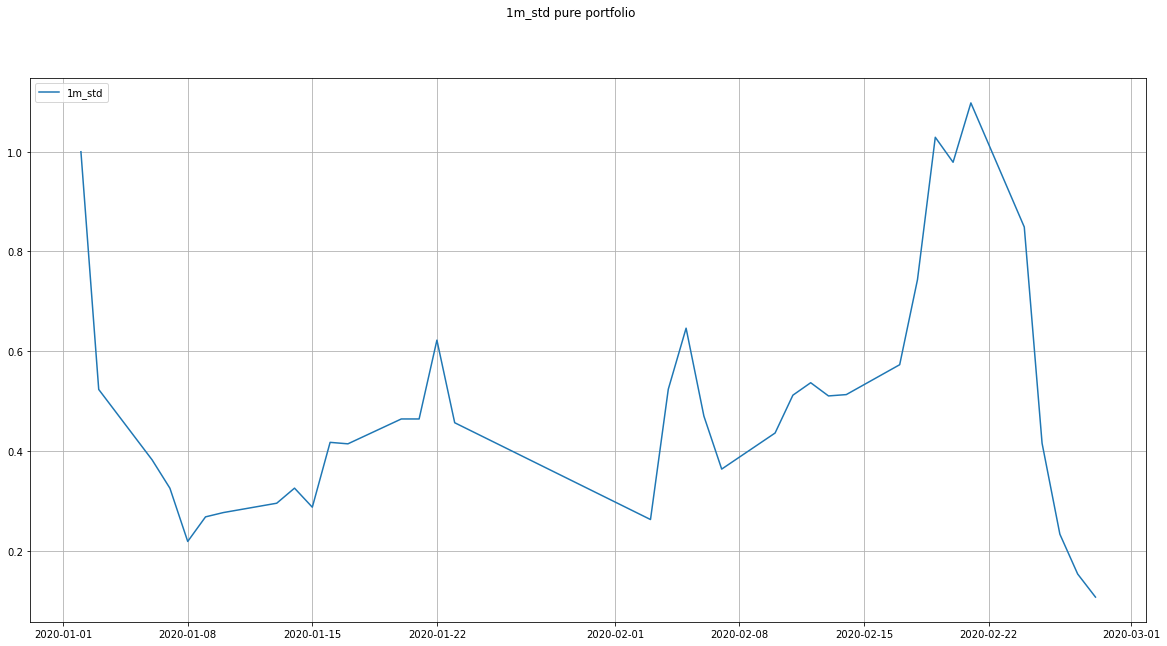

In [9]:
# 绘制分组回测净值图
plt.figure(figsize=(20, 10))
plt.suptitle('%s pure portfolio' % factor_name)
ax1 = plt.subplot(111)
ax1.plot(pd.to_datetime(pure_value_df.index), pure_value_df[factor_name])
ax1.grid(True)
ax1.legend(labels=[factor_name], loc=2)
plt.savefig('%s pure portfolio.jpg' % factor_name)
plt.show()